In [1]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import jinja2
import json
import re
import os

In [2]:
path = "../data/txts/SE"

In [3]:
for dirpath, dirnames, filenames in os.walk(path):
    fnames = [f for f in filenames if f.endswith(".txt")]
print(f"Number of files: {len(fnames)}")

Number of files: 1143


## Average article length in pages:

Mean: 18.26159230096238 | Std: 6.4370417488122 | Max: 46 | Min: 2


(array([ 43.,  82., 237., 305., 275., 142.,  35.,  16.,   4.,   4.]),
 array([ 2. ,  6.4, 10.8, 15.2, 19.6, 24. , 28.4, 32.8, 37.2, 41.6, 46. ]),
 <BarContainer object of 10 artists>)

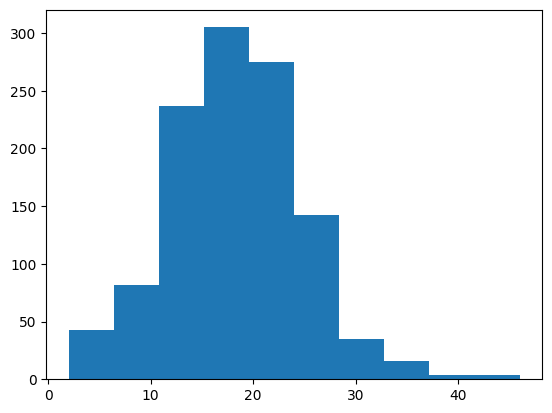

In [4]:
pdf_lens = []
for f in fnames:
    with open(os.path.join(path, f), "r") as infile:
        pgs = infile.read().split("<newpage>")
    pdf_lens.append(len(pgs))
print(f"Mean: {np.mean(pdf_lens)} | Std: {np.std(pdf_lens)} | Max: {np.max(pdf_lens)} | Min: {np.min(pdf_lens)}")
plt.hist(pdf_lens)

## Average page length in tokens:

In [5]:
# go one dir up
llama_dir = os.path.join(os.getcwd(), "..", "..", "codellama", "CodeLlama-7b-Instruct-hf")
tokenizer = AutoTokenizer.from_pretrained(llama_dir, local_files_only=True)

Mean: 1061.2163560580655 | Std: 403.9954893710908 | Max: 3978 | Min: 0


(array([1.496e+03, 3.455e+03, 7.356e+03, 7.144e+03, 1.148e+03, 2.580e+02,
        9.000e+00, 5.000e+00, 0.000e+00, 2.000e+00]),
 array([   0. ,  397.8,  795.6, 1193.4, 1591.2, 1989. , 2386.8, 2784.6,
        3182.4, 3580.2, 3978. ]),
 <BarContainer object of 10 artists>)

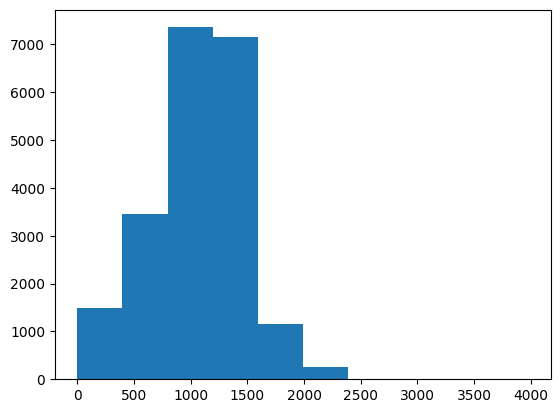

In [6]:
pg_lens = []
for f in fnames:
    with open(os.path.join(path, f), "r") as infile:
        pgs = infile.read().split("<newpage>")
        for pg in pgs:
            pg_lens.append(len(tokenizer.tokenize(pg)))
print(f"Mean: {np.mean(pg_lens)} | Std: {np.std(pg_lens)} | Max: {np.max(pg_lens)} | Min: {np.min(pg_lens)}")
plt.hist(pg_lens)

LLaMA2-Code has a functional context length of 16k tokens.

## Prompt Engineering

In [7]:
class jinjitsu():
    def __init__(self, template_dir, template_file, exampleVars):
        self.templateLoader = jinja2.FileSystemLoader(searchpath=template_dir)
        self.templateEnv = jinja2.Environment( loader=self.templateLoader )
        self.template = self.templateEnv.get_template( template_file )
        self.example = self.template.render( exampleVars )

    def render(self, templateVars):
        return self.template.render( templateVars )

In [8]:
with open("../prompts/examples/txt_example.json", "r") as infile:
        exampleVars = json.load(infile)

In [9]:
jinjaLoader = jinjitsu("../prompts", "txt.jinja", exampleVars)

### Average prompt length in tokens:

In [10]:
# runs for a moment
for pgnum in range(1, 6):
    print(f"Prompt length with {pgnum} page(s):")
    prompt_lens = []
    for f in fnames:
        with open(os.path.join(path, f), "r") as infile:
            pgs = infile.read().split("<newpage>")
        templateVars = {"input": "\n".join(pgs[:pgnum]), "output": ""}
        prompt = "\n".join([jinjaLoader.example, jinjaLoader.render( templateVars )])
        prompt_lens.append(len(tokenizer.tokenize(prompt)))
    print(f"Mean: {np.mean(prompt_lens)} | Std: {np.std(prompt_lens)} | Max: {np.max(prompt_lens)} | Min: {np.min(prompt_lens)}")

Prompt length with 1 page(s):
Mean: 1658.4068241469815 | Std: 12.081519069939723 | Max: 1698 | Min: 1622
Prompt length with 2 page(s):
Mean: 2714.3333333333335 | Std: 242.7395336360587 | Max: 3244 | Min: 2029
Prompt length with 3 page(s):
Mean: 3895.2300962379704 | Std: 438.70997209905187 | Max: 4754 | Min: 2107
Prompt length with 4 page(s):
Mean: 5034.210848643919 | Std: 655.766973758063 | Max: 6277 | Min: 2107
Prompt length with 5 page(s):
Mean: 6140.517060367454 | Std: 897.369125177485 | Max: 7826 | Min: 2107


### Correct JSON response length in tokens:

In [11]:
all_false = json.dumps({"quantitative": False, "qualitative": False, "primary/secondary": False, "tertiary": False, "inequality": False, "nonstructural": False, "culture": False, "school": False, "state": False, "labor": False, "comparative": False, "methods": False})
print(f"Length of max expected JSON output in tokens: {len(tokenizer.tokenize(all_false))}")

Length of max expected JSON output in tokens: 74
